In [1]:
# Author: Lee Yat Shun, Jasper
# Copyright (c) 2023 Lee Yat Shun, Jasper. All rights reserved.

In [2]:
import sys
sys.path.insert(0, '..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from caviar import CaviarModel
from backtesting import backtest
from var_tests import binomial_test, kupiec_pof_test, christoffersen_test, traffic_light_test

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
df = yf.download('SPY', start='2000-12-01')
df['Log Return'] = df['Close'].apply(lambda x: np.log(x)).diff()
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Log Return
Date,,,,,,,
2000-11-30,132.50000,133.50000,129.75000,132.281250,86.998985,11201600,NaN
2000-12-01,133.18750,134.06250,131.00000,132.218750,86.957840,7587200,-0.000473
2000-12-04,131.87500,133.87500,131.50000,133.343750,87.697716,6996600,0.008473
2000-12-05,134.87500,138.25000,134.40625,137.718750,90.575096,8883400,0.032283
2000-12-06,137.78125,138.34375,135.03125,135.515625,89.126137,12888000,-0.016127


In [5]:
returns = df['Log Return'].dropna()
low_open_log_difference = (df['Low'].apply(lambda x: np.log(x)) - df['Open'].apply(lambda x: np.log(x))).dropna()

In [6]:
in_samples = returns['2001':'2015'] * 100
out_of_samples = returns['2016':] * 100

In [7]:
# initiate parameter
quantile = 0.05 # 5% VAR

In [8]:
# instantiation
caviar_model = CaviarModel(quantile, model='igarch', method='mle')
caviar_model

CaviarModel(quantile=0.05, model=igarch, method=mle, G=10, tol=1e-10, LAGS=4)

In [9]:
caviar_model.fit(in_samples)

Final loss: 0.12621099620496706
Time taken(s): 2.91


In [10]:
caviar_model.beta_summary()

,coefficient,S.E. of beta,pval of beta
beta1,0.039023,0.021303,3.349385e-02
beta2,0.917657,0.011261,0.000000e+00
beta3,0.224646,0.027353,1.080623e-16


### Backtesting on the out of samples

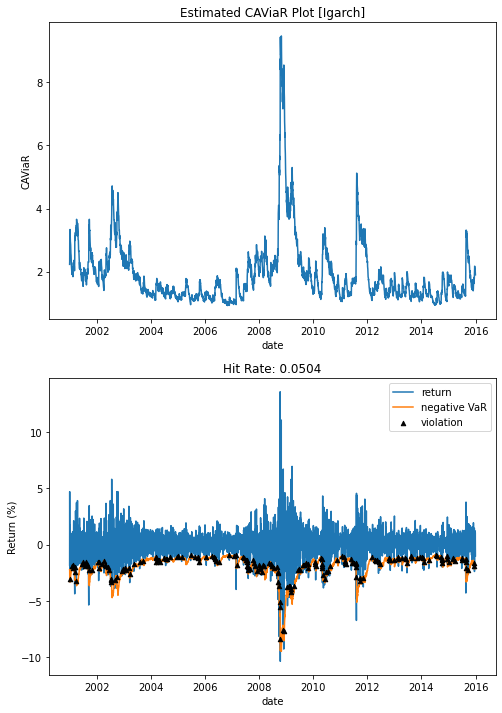

In [11]:
# in sample
caviar_model.plot_caviar(in_samples, 'in')

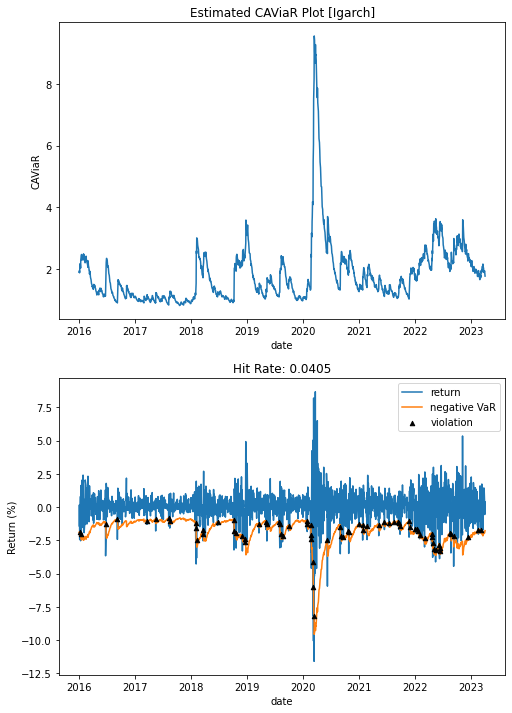

In [12]:
# out of sample
caviar_model.plot_caviar(out_of_samples, 'out')

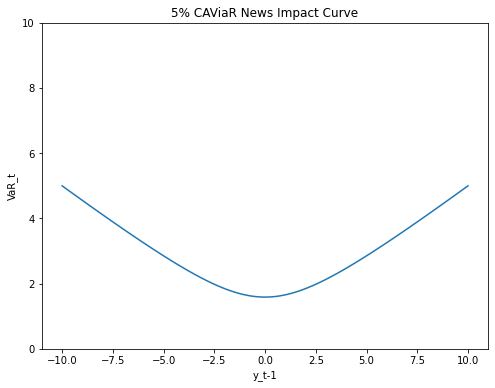

In [13]:
caviar_model.plot_news_impact_curve(VaR=-1.645)

### VaR Test

In [14]:
in_VaR = caviar_model.predict(in_samples, 'in')

In [15]:
out_VaR = caviar_model.predict(out_of_samples, 'out')

In [16]:
(out_of_samples < out_VaR[:-1]).value_counts(normalize=True)

False    0.959519
True     0.040481
Name: Log Return, dtype: float64

In [17]:
# The null hypothesis states that the current VaR violations are uncorrelated with past violations.

print(caviar_model.dq_test(in_samples, 'in'))
print(caviar_model.dq_test(out_of_samples, 'out'))

0.8258627506238979
0.9976255424481933


In [18]:
# H0: the obs ~ binomial(p)

print(binomial_test(in_samples, in_VaR[:-1], caviar_model.quantile))
print(binomial_test(out_of_samples, out_VaR[:-1], caviar_model.quantile))

0.9107644446889023
0.06773535587419785


In [19]:
# H0: the observed failure rate is equal to the failure rate suggested by the confidence interval.

print(kupiec_pof_test(in_samples, in_VaR[:-1], caviar_model.quantile))
print(kupiec_pof_test(out_of_samples, out_VaR[:-1], caviar_model.quantile))

nan
0.9462054900539612


In [20]:
# null hypothesis: the observations are independent of each other

print(christoffersen_test(in_samples, in_VaR[:-1]))
print(christoffersen_test(out_of_samples, out_VaR[:-1]))

nan
0.9627517227168826


In [21]:
# Basel Committee (1996)

print(traffic_light_test(in_samples, in_VaR[:-1], caviar_model.quantile))
print(traffic_light_test(out_of_samples, out_VaR[:-1], caviar_model.quantile))

('green', 0.401558474694067, 0)
('green', 0.7288363123094815, 0)


### Forecast (totally unknown)

In [22]:
if len(out_VaR)-1 == len(out_of_samples):
    print('Day T+1 VaR forecast:', out_VaR[-1])

Day T+1 VaR forecast: -1.7129118028048906


### Mean reversion property?

count    74.000000
mean      0.314240
std       1.900937
min      -4.272228
25%      -0.578159
50%       0.228099
75%       1.167783
max       8.202809
Name: Log Return, dtype: float64
Date
2016-01-08    0.988963
2016-01-14    1.005067
2016-06-27    0.986903
2016-09-12    1.000962
2017-03-22    1.003314
                ...   
2022-08-29    1.281516
2022-09-14    1.286397
2022-12-16    1.265226
2023-02-22    1.263481
2023-03-10    1.245117
Name: Log Return, Length: 74, dtype: float64


<AxesSubplot:ylabel='Frequency'>

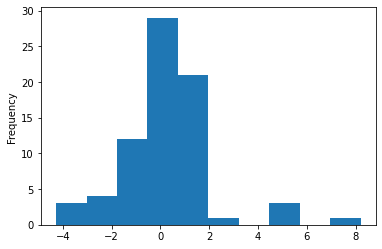

In [23]:
the_following_day = np.array(range(len(out_of_samples)))[out_of_samples < out_VaR[:-1]] + 1

print(out_of_samples.iloc[the_following_day].describe())
print((out_of_samples.iloc[the_following_day]/100 + 1).cumprod())

out_of_samples.iloc[the_following_day].plot.hist()

### Trading Strategy (Stop Loss)

In [24]:
out_low_open_log_difference = low_open_log_difference.loc[out_of_samples.index]
(out_low_open_log_difference * 100 < out_VaR[:-1]).value_counts(normalize=True)

False    0.948031
True     0.051969
dtype: float64

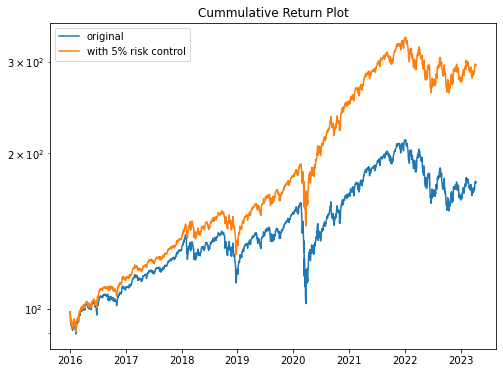

,annualized return (with CAViaR),cummulative return (with CAViaR),max. drawdown (with CAViaR),annualized return (original),cummulative return (original),max. drawdown (original)
0,0.161403,1.960631,-0.241037,0.08078,0.756827,-0.3614


In [25]:
# with 0.2% transaction cost
stat = backtest(out_of_samples, out_low_open_log_difference, out_VaR[:-1], caviar_model.quantile, ntl=100, penalty=0.002)

pd.DataFrame([stat], columns=[
    'annualized return (with CAViaR)',
    'cummulative return (with CAViaR)',
    'max. drawdown (with CAViaR)',
    'annualized return (original)',
    'cummulative return (original)',
    'max. drawdown (original)',
])